# Supervised Music Classifications with a CNN 


In [25]:
# check current working directory if necessary... 
print(os.getcwd())

/Users/nicolasvogel/Dokumente/16_ZHAW_MSc/V5_6_NeuralNetworks&DeepLearning/NNDL_Project_Repo


### Set random seed

In [12]:
import torch
import numpy as np
import random

# Set seed for PyTorch
torch.manual_seed(42)

# Set seed for NumPy
np.random.seed(42)

# Set seed for Python's random module
random.seed(42)

# If you are using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # if you are using multi-GPU

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Load images and safe them in to an image list

In [26]:
import os
from PIL import Image

input_dir = "./images_original/blues"

# load images one after another - useful for images one by one
for image in os.listdir(input_dir):
    img = Image.open(os.path.join(input_dir, image))
    # do whatever you like to do with the img

# load all images data at in to list
image_list = [Image.open(os.path.join(input_dir, image)) for image in os.listdir(input_dir)]


### Print first images to get an idea of the data

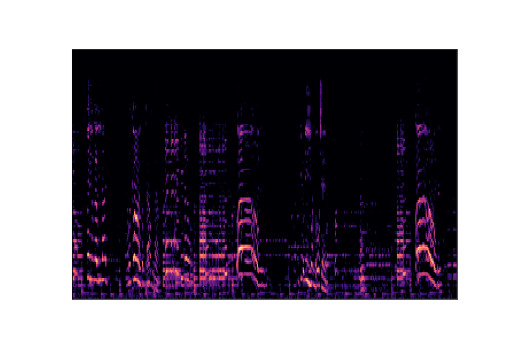

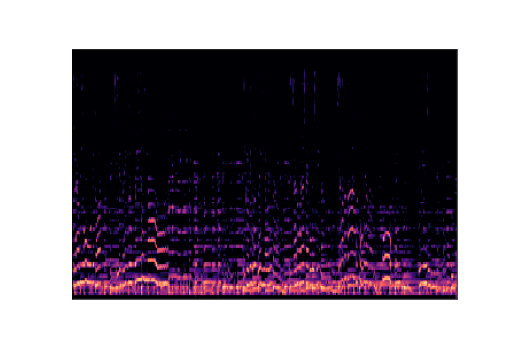

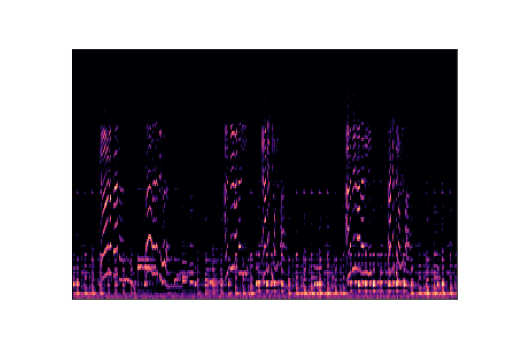

In [28]:
import matplotlib.pyplot as plt

# Print first 3 images in the list
counter = 0
for img in image_list:
    if counter < 3: 
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
        counter += 1
    else: 
        break

### Prepare data for training
#### Load data into tensors and create subset
Split the datafolder into test and training data (not equal across genres yet!) -> unbalanced

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset
import collections

In [ ]:


# Data directory
data_dir = "./images_original"

# Load full the dataset with original image size
dataset = ImageFolder(data_dir, transform=transforms.Compose([transforms.Resize((288, 432)), # Adjust to original image size
transforms.ToTensor()]))

# Load the dataset with resized images
# dataset = ImageFolder(data_dir, transform=transforms.Compose([
#     transforms.Resize((150, 150)),
#     transforms.ToTensor()]))

# Load a subset of the dataset
# criterion for subset, and counter initialization
class_counts = collections.defaultdict(int)
max_per_class = 10
selected_indices = []

# Iterate through the dataset and select indices of spectrograms
for idx, (img, label) in enumerate(dataset):
    if class_counts[label] < max_per_class:
        selected_indices.append(idx)
        class_counts[label] += 1
    # stopping criteria if all genres contain 10 spectorgrams
    if len(class_counts) == len(dataset.classes) and all(c >= max_per_class for c in class_counts.values()):
        break

# created subset with the selected indices
subset = Subset(dataset, selected_indices)

# check length of subset 
print(f"Spectrograms in subset: {len(subset)}")




### Split the dataset into training and testing sets

In [33]:
# Define the split ratio
train_ratio = 0.8
test_ratio = 0.2

#==============  Train Test split for whole dataset ============== #
# # Calculate the number of samples for training and testing
# train_size = int(train_ratio * len(dataset))
# test_size = len(dataset) - train_size
# 
# # Randomly split the dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# 
# # Create data loaders (load the train and validation into batches)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# 
# # Print the number of samples in each set
# print(f"Number of training samples: {len(train_dataset)}") # one sample from the genre jazz is missing --> only 999 instead of 1000 samples
# print(f"Number of testing samples: {len(test_dataset)}")
# print(train_dataset)


#==============  Train Test split for sub dataset ============== #
# Calculate the number of samples for training and testing
train_size = int(train_ratio * len(subset))
test_size = len(subset) - train_size

# Randomly split the dataset
train_subset, test_subset = random_split(subset, [train_size, test_size])

# Create data loaders (load the train and validation into batches)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Print the number of samples in each set
print(f"Number of training samples: {len(train_subset)}") # one sample from the genre jazz is missing --> only 999 instead of 1000 samples
print(f"Number of testing samples: {len(test_subset)}")

Number of training samples: 80
Number of testing samples: 20


Look at first 5 images of training dataset (function proposed by microsoft copilot)

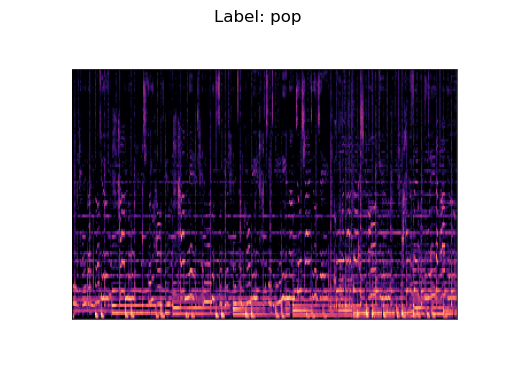

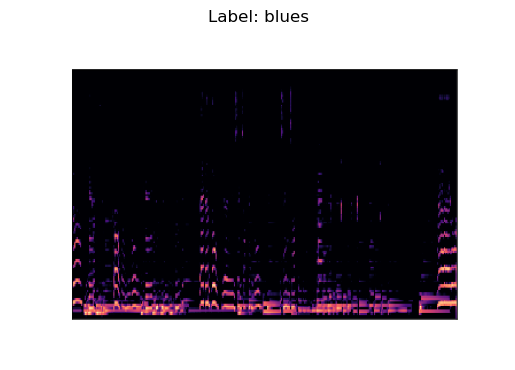

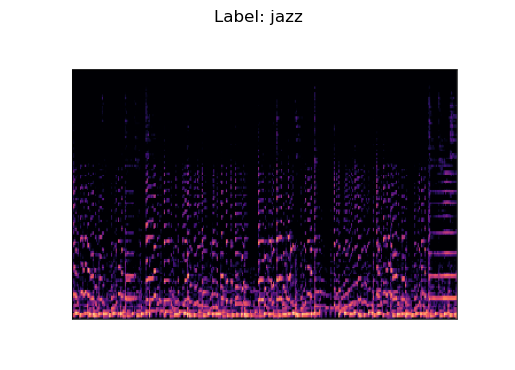

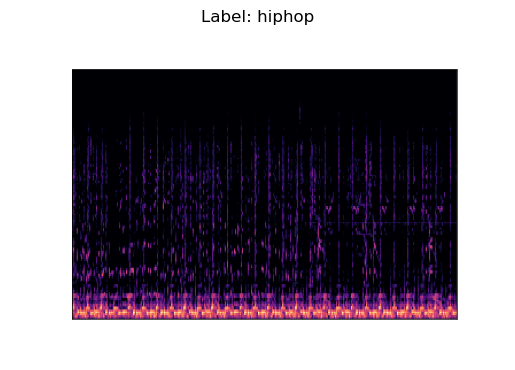

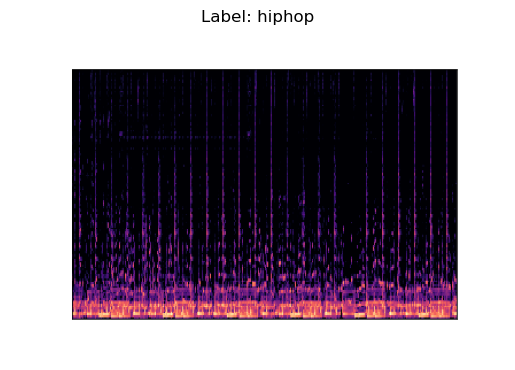

In [29]:
import matplotlib.pyplot as plt

# Function to show an image
def show_image(img, title=None):
    img = img.permute(1, 2, 0)  # Change the order of dimensions
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Display a few images from the training dataset
for i in range(5):  # Change the range to display more or fewer images
    img, label = train_dataset[i]
    show_image(img, title=f"Label: {train_dataset.dataset.classes[label]}")
    



Recall tensor shape

torch.Size([3, 288, 432]) 0
torch.Size([3, 288, 432]) 2


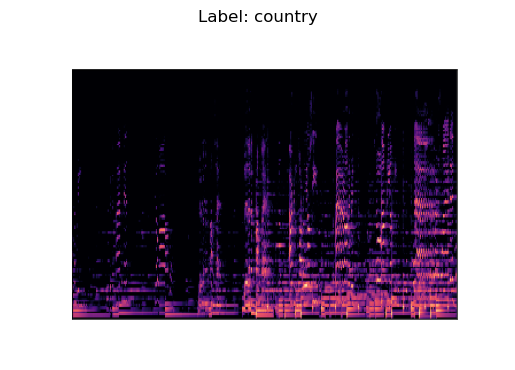

In [34]:
img, label = dataset[0]
print(img.shape, label)
img, label = train_dataset[0]
print(img.shape, label) # prints size of first image: 3 channels (RGB), height, width
show_image(img, title=f"Label: {train_dataset.dataset.classes[label]}")

#output :
#torch.Size([3, 288, 432]) 0 # has label 0 which represents genre blues,
#torch.Size([3, 288, 432]) 8 # first image of train ddset (8 = raggae)

See all 10 music genres (classes) of dataset

In [35]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


Different printing function based on tutorial (Medium article)

Label : blues


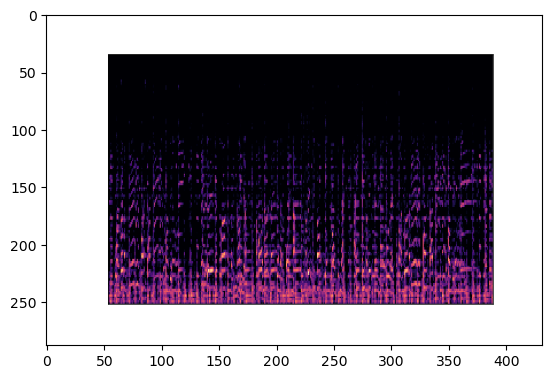

In [36]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

### Visualize training batch (batch size 32 see above)

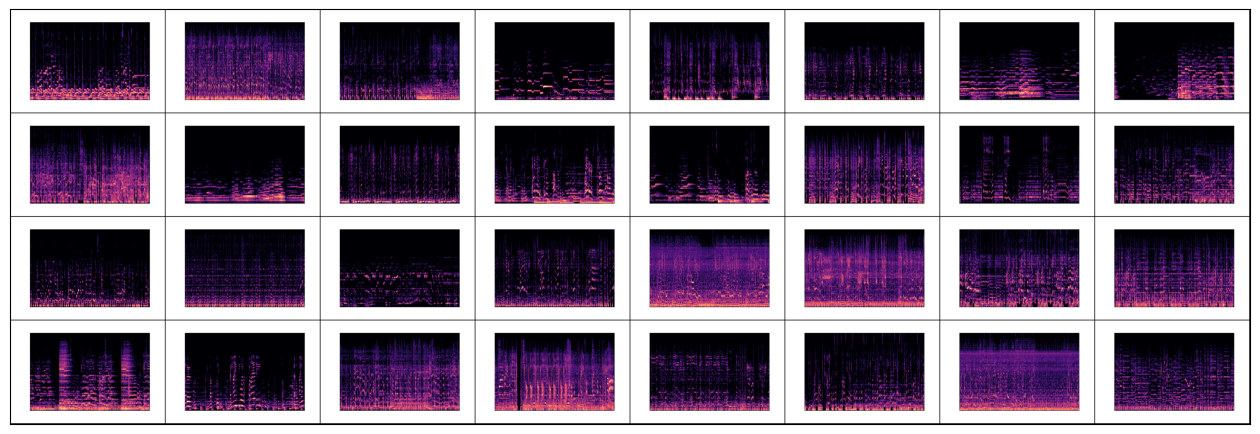

In [37]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break

show_batch(train_loader)

### Base Model for Image Classification

This base class is used to develop all neural networks. We add functionalities to the base to train the model, validate the model and get the result for each epoch. It's reusable and can be used for any image classification model, no need to rewrite this every time.

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'],result['val_loss'], result['val_acc']))

Concepts to refine the model: Convolution, Padding, Stride, Maxpooling

### CNN Model for Classification

Final model with 3 CNN blocks, each consisting of 2 convolutional layers & 1 max-pooling layer. Relu activation function is used to remove negative values from the feature map. Stride(1, 1), padding = 1.After applying convolution and feature extracting a flatten layer is used to flatten the tensor from 3 to 1 dimension. Then 3 linear layers are added to reduce the size of the tensor and learn the features.

In [40]:

class MusicGenreClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(497664,1024), # because our images are not 150x150 first number isnot 82944
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10) # we have 10 classes and not 6
        )

    def forward(self, xb):
        return self.network(xb)

### Hyperparameters, Model Training, And Evaluation:
Now we have to train the music genre classification model on the training dataset. That defines the fit, evaluation and accuracy methods.

In [41]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):§

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [42]:
# Instantiate the model
model = MusicGenreClassification()

# Number of epochs
num_epochs = 30

# Optimizer
opt_func = torch.optim.Adam

# Learning rate
lr = 0.001

# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_loader, test_loader, opt_func) # in online article they used val_loader (validation) instead of test_loader

Epoch [0], train_loss: 2.5396, val_loss: 2.3019, val_acc: 0.1116
Epoch [1], train_loss: 2.3033, val_loss: 2.3038, val_acc: 0.1116


KeyboardInterrupt: 

In [86]:
# Check the number of classes in the dataset
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 10
